In [1]:
import os
from collections.abc import Callable
from pathlib import Path
from typing import Any

import cv2
import numpy as np
import torch
from torch import Tensor
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
from srcnn import SRCNN

In [3]:
class VideoFrameDataset(Dataset):
    def __init__(
        self, video_path: str, transform: Callable[[np.ndarray], Any] = None
    ) -> None:
        self.frames: list[np.ndarray] = []
        capture = cv2.VideoCapture(video_path)
        while True:
            success, frame = capture.read()
            if not success:
                break
            self.frames.append(frame)
        self.transform = transform

    def __len__(self) -> int:
        return len(self.frames)

    def __getitem__(self, index: int):
        frame = self.frames[index]
        if self.transform:
            frame = self.transform(frame)
        return frame

In [4]:
target_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((720, 1280)),
        v2.ToDtype(torch.float32, scale=False),
    ]
)

input_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((240, 427)),
        v2.Resize((720, 1280)),
        v2.ToDtype(torch.float32, scale=False),
    ]
)


def transform(frame: np.ndarray) -> tuple[Tensor, Tensor]:
    return input_transform(frame), target_transform(frame)

In [5]:
video_path = os.fspath(Path.cwd().glob("*.mp4").__next__())
dataset = VideoFrameDataset(video_path, transform)
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    pin_memory_device="cuda",
)

In [6]:
model_args = {
    "f1": 9,
    "f2": 1,
    "f3": 5,
    "n1": 64,
    "n2": 32,
    "qconfig": torch.ao.quantization.get_default_qat_qconfig("x86"),
}
device = "cuda"

In [7]:
model = SRCNN(**model_args).to(device)
optimizer = Adam(model.parameters(), lr=2e-4)

model.train()
epoch_losses = []
for epoch in range(1, 20 + 1):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    batch_losses = []

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, quant=False)
        loss = mse_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        progress_bar.set_postfix(batch_loss=batch_loss)

    epoch_loss = np.mean(batch_losses)
    print(f"Epoch loss: {epoch_loss}")

    if len(epoch_losses) == 0 or epoch_loss < min(epoch_losses):
        print("Saving best.pth")
        torch.save(model.state_dict(), "best.pth")

    epoch_losses.append(epoch_loss)

Epoch 1: 100%|██████████| 151/151 [00:30<00:00,  5.00it/s, batch_loss=203]   


Epoch loss: 3002.0770039337363
Saving best.pth


Epoch 2: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=73]  


Epoch loss: 121.80639997065462
Saving best.pth


Epoch 3: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=47.9]


Epoch loss: 69.01009735208473
Saving best.pth


Epoch 4: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=40.6]


Epoch loss: 56.35091084360287
Saving best.pth


Epoch 5: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=47.5]


Epoch loss: 48.62430707666258
Saving best.pth


Epoch 6: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=28.2]


Epoch loss: 44.98258900168716
Saving best.pth


Epoch 7: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=48.2]


Epoch loss: 42.76208181570697
Saving best.pth


Epoch 8: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=38.2]


Epoch loss: 40.311033312058605
Saving best.pth


Epoch 9: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=31.9]


Epoch loss: 40.304619643861884
Saving best.pth


Epoch 10: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=41.6]


Epoch loss: 40.00980216777877
Saving best.pth


Epoch 11: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=46.8]


Epoch loss: 35.65131389542131
Saving best.pth


Epoch 12: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, batch_loss=35.7]


Epoch loss: 33.21321128693638
Saving best.pth


Epoch 13: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, batch_loss=34.6]


Epoch loss: 31.873152524430232
Saving best.pth


Epoch 14: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, batch_loss=36.5]


Epoch loss: 30.7581089600822
Saving best.pth


Epoch 15: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=26.4]


Epoch loss: 30.354926368258646
Saving best.pth


Epoch 16: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=32]  


Epoch loss: 32.05261307520582


Epoch 17: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, batch_loss=29.6]


Epoch loss: 28.36982574841834
Saving best.pth


Epoch 18: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=24.6]


Epoch loss: 27.70491983401065
Saving best.pth


Epoch 19: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=34.1]


Epoch loss: 28.076642832219207


Epoch 20: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=25.7]

Epoch loss: 30.06124032885823


Text(0, 0.5, 'Loss')

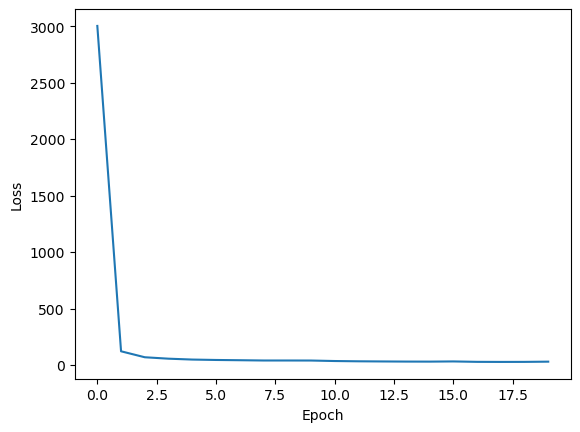

In [8]:
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [9]:
model = SRCNN(**model_args).to(device)
model.load_state_dict(torch.load("best.pth"))
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)

optimizer = Adam(model_qat.parameters(), lr=4e-5)

epoch_losses = []
for epoch in range(1, 10 + 1):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    batch_losses = []

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_qat(inputs, quant=True)
        loss = F.mse_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        progress_bar.set_postfix(batch_loss=batch_loss)

    epoch_loss = np.mean(batch_losses)
    print(f"Epoch loss: {epoch_loss}")

    if len(epoch_losses) == 0 or epoch_loss < min(epoch_losses):
        print("Saving best_qat.pth")
        torch.save(model_qat.state_dict(), "best_qat.pth")

    epoch_losses.append(epoch_loss)

/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
Epoch 1:   0%|          | 0/151 [00:00<?, ?it/s]

/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/aten/src/ATen/native/TensorCompare.cpp:677.)
  return torch.fused_moving_avg_obs_fake_quant(
Epoch 1: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=43.9]


Epoch loss: 45.74601424766692
Saving best_qat.pth


Epoch 2: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=41.6]


Epoch loss: 41.84846393004158
Saving best_qat.pth


Epoch 3: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=41.5]


Epoch loss: 42.18019797470396


Epoch 4: 100%|██████████| 151/151 [00:34<00:00,  4.40it/s, batch_loss=42]  


Epoch loss: 40.121858192595425
Saving best_qat.pth


Epoch 5: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=44.6]


Epoch loss: 40.398622563343174


Epoch 6: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=41.3]


Epoch loss: 40.52642679530264


Epoch 7: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=45.1]


Epoch loss: 41.5888076681175


Epoch 8: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=59.6]


Epoch loss: 45.43755920359631


Epoch 9: 100%|██████████| 151/151 [00:34<00:00,  4.41it/s, batch_loss=41.9]


Epoch loss: 42.702483095080645


Epoch 10: 100%|██████████| 151/151 [00:34<00:00,  4.41it/s, batch_loss=40]  

Epoch loss: 40.800882352108985


Text(0, 0.5, 'Loss')

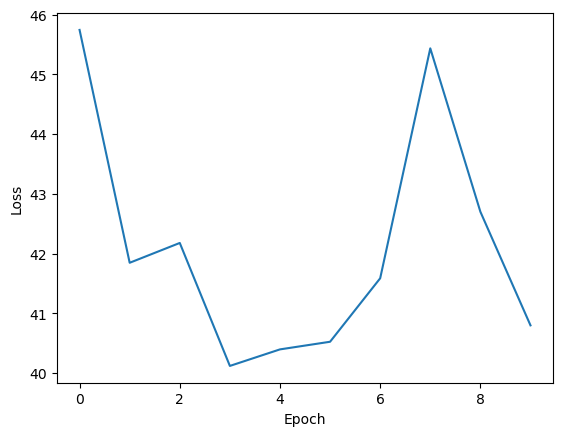

In [10]:
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [8]:
model = SRCNN(**model_args).to(device)
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)
model_qat.load_state_dict(torch.load("best_qat.pth"))
model_qat.cpu()
model_qat.eval()
model_converted = torch.ao.quantization.convert(model_qat)
torch.save(model_converted.state_dict(), "converted.pth")

In [9]:
def show_image(image: np.ndarray | Tensor) -> None:
    if isinstance(image, Tensor):
        image = image.cpu().detach().numpy()
    if image.shape[0] == 1:
        image = image.squeeze(0)
    if image.shape[0] == 3:
        image = image.transpose((1, 2, 0))
    image = image.clip(0, 255).astype(np.uint8)
    plt.axis("off")
    plt.imshow(image)

/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


Text(0.5, 1.0, 'Target')

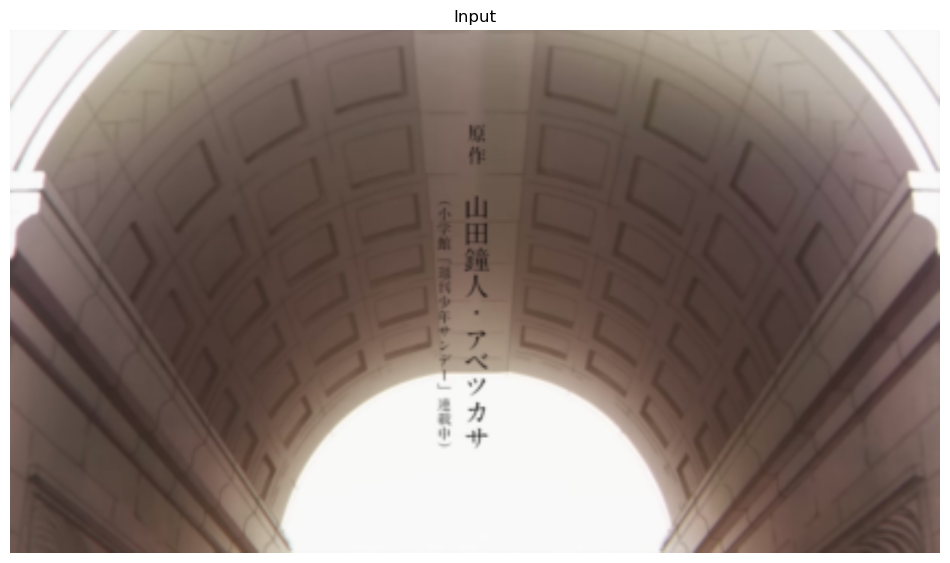

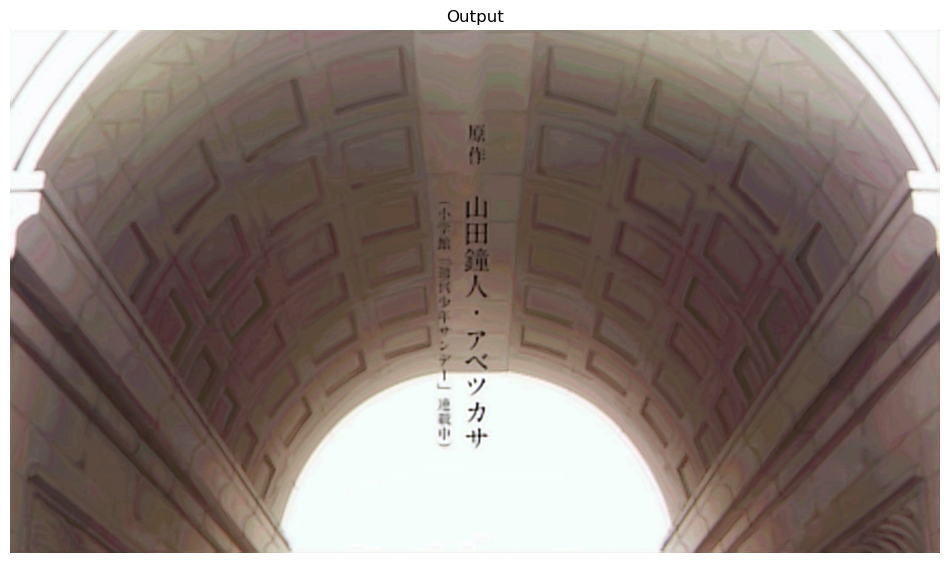

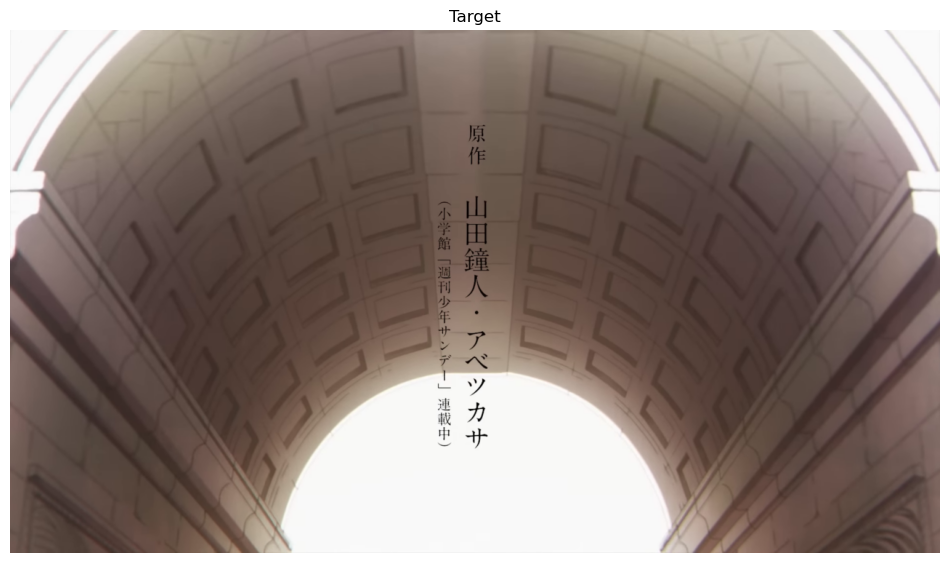

In [12]:
model = SRCNN(**model_args)
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)
model_qat.eval()
model_converted = torch.ao.quantization.convert(model_qat)
model_converted.load_state_dict(torch.load("converted.pth"))

test_input, test_target = dataset[100]
test_input = test_input.unsqueeze(0)
test_output = model_converted(test_input, quant=True)

FIGURE_SIZE = (12, 8)

plt.figure(figsize=FIGURE_SIZE)
show_image(test_input)
plt.title("Input")

plt.figure(figsize=FIGURE_SIZE)
show_image(test_output)
plt.title("Output")

plt.figure(figsize=FIGURE_SIZE)
show_image(test_target)
plt.title("Target")